In [7]:
import pandas as pd
import numpy as np
import theano
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from nolearn.lasagne import NeuralNet, TrainSplit
import warnings
from lasagne.layers import DenseLayer
from lasagne.layers import InputLayer
from lasagne.layers import DropoutLayer
from lasagne.updates import nesterov_momentum, sgd
from lasagne.objectives import squared_error, categorical_crossentropy, binary_crossentropy
from lasagne.nonlinearities import sigmoid, rectify, softmax, linear, tanh, rectify, leaky_rectify, very_leaky_rectify
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.utils.validation import NonBLASDotWarning
import theano
import numpy as np
import matplotlib.pyplot as plt

from dataset import get_data
from gini import normalized_gini
from numpy import log
from sklearn.metrics import confusion_matrix
from lasagne.layers import DenseLayer
from lasagne.layers import InputLayer
from lasagne.layers import DropoutLayer
from lasagne.updates import nesterov_momentum, sgd
from lasagne.objectives import squared_error, categorical_crossentropy, binary_crossentropy
from lasagne.nonlinearities import sigmoid, rectify, softmax, linear, tanh
from nolearn.lasagne import NeuralNet, TrainSplit

warnings.simplefilter('always', NonBLASDotWarning)
%matplotlib inline

dat_x_orig, dat_y_orig, lb_x_orig, lb_ind = get_data()

Load data

In [8]:
dat_x_orig, dat_y_orig, lb_x_orig, lb_ind = get_data()

Relabel and scale

In [59]:
def labels(n):
    if n <= 1:
        return 0
    elif n <=4:
        return 1
    else:
        return 2

nplabels = np.vectorize(labels)

scaler = preprocessing.StandardScaler().fit(dat_x_orig)
dat_x = scaler.transform(dat_x_orig)
lb_x = scaler.transform(lb_x_orig)
dat_y = nplabels(dat_y_orig) #** 0.75

Split dataset into train/test

In [89]:
train_index, test_index = train_test_split(range(dat_x.shape[0]), test_size=0.15, random_state=103)

train_x = dat_x[train_index, :]
train_y = dat_y[train_index]
cv_x = dat_x[test_index, :]
cv_y = dat_y[test_index]
cv_y_true = dat_y_orig[test_index]

Prepare for Theano

In [90]:
train_x = np.asarray(train_x, dtype = theano.config.floatX)
train_y = np.asarray(train_y, dtype = 'int32')
cv_x = np.asarray(cv_x, dtype = theano.config.floatX)
cv_y = np.asarray(cv_y, dtype = 'int32')

# Neural Network with 1059503 learnable parameters

## Layer information

  #  name        size
---  --------  ------
  0  input        111
  1  dropout0     111
  2  hidden1      500
  3  dropout1     500
  4  hidden2      500
  5  hidden3      500
  6  hidden4      500
  7  hidden5      500
  8  output         3

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  -----
      1       1.09722       1.06911      1.02629      0.41014  3.72s
      2       1.07483       1.06116      1.01288      0.42171  3.45s
      3       1.07055       1.05911      1.01080      0.42166  3.54s
      4       1.06781       1.05893      1.00839      0.41887  3.19s
      5       1.06453       1.05730      1.00683      0.42623  3.12s
      6       1.06428       1.05714      1.00675      0.42864  3.40s
      7       1.06263       1.05750      1.00485      0.42542  3.57s
      8       1.06027       1.05682      1.00326      0.42922  3

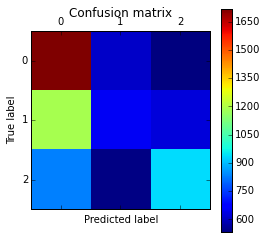

0.262895901444


In [104]:

def on_epoch_finished(obj, train_history):
    if (len(train_history) > 5):
        inLastEight = any([h['valid_loss_best'] for h in  train_history[-4:-1]] +
                          [train_history[-1]['valid_loss'] < train_history[-2]['valid_loss'],
                           train_history[-1]['valid_loss'] < train_history[-3]['valid_loss'],
                           ])
        if not inLastEight:
            print("Stopping early")
            raise StopIteration

def NeuralNetConstructor(num_features, max_epochs=5, update_learning_rate=0.2, verbose=1):
    layers0 = [
        ('input', InputLayer),
        ('dropout0', DropoutLayer),
        ('hidden1', DenseLayer),
        ('dropout1', DropoutLayer),
        ('hidden2', DenseLayer),
        ('hidden3', DenseLayer),
        ('hidden4', DenseLayer),
        ('hidden5', DenseLayer),
        ('output', DenseLayer)]

    #LSTMLayer
    net0 = NeuralNet(
        layers=layers0,

        input_shape=(None, num_features),
        input_nonlinearity=sigmoid,

        dropout0_p=0.2,

        hidden1_num_units=500, #75, #20,
        hidden1_nonlinearity=rectify,

        dropout1_p=0.2,

        hidden2_num_units=500, #70, #24,
        hidden2_nonlinearity=rectify,

        hidden3_num_units=500, #70, #24,
        hidden3_nonlinearity=rectify,

        hidden4_num_units=500, #70, #24,
        hidden4_nonlinearity=rectify,

        hidden5_num_units=500, #70, #24,
        hidden5_nonlinearity=sigmoid,

        output_num_units=3,
        output_nonlinearity=softmax,

        on_epoch_finished=[on_epoch_finished],

        objective_loss_function=categorical_crossentropy, #binary_crossentropy, #squared_error, categorical_crossentropy
        update=nesterov_momentum,
        update_learning_rate=update_learning_rate, #0.02,
        update_momentum=0.9,
        train_split=TrainSplit(eval_size=0.2),
        verbose=verbose,
        regression=False,
        max_epochs=max_epochs)

    return net0

network = NeuralNetConstructor(111, max_epochs=1000, update_learning_rate=0.01, verbose=1)
network.fit(train_x, train_y)
cv_preds = network.predict(cv_x)

cm = confusion_matrix(cv_y, cv_preds)
print(cm)

#pd.DataFrame(cv_preds).hist()

plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
print(normalized_gini(cv_y_true, cv_preds))

# PREV

[[1444  810  609]
 [ 936  845  692]
 [ 623  674 1017]]


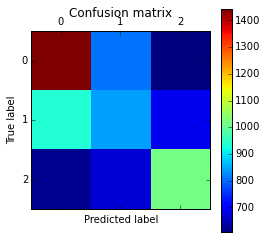

0.275404386283


In [102]:
print(cm)

#pd.DataFrame(cv_preds).hist()

plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(normalized_gini(cv_y_true, cv_preds))

In [94]:
print(normalized_gini(cv_y_true, cv_preds))

0.263275728938
